In [ ]:
import os
import sys
os.chdir('..')

if os.getcwd() not in sys.path:
    sys.path.append(os.getcwd())

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
dataset = pd.read_csv('data/cleaned_tripadvisor_reviews.csv')

In [7]:
dataset.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [8]:
print('the shape of the dataset is: ', dataset.shape)
print('')
print('number of NA values: ', dataset.isna().sum())

the shape of the dataset is:  (20491, 2)

number of NA values:  Review    0
Rating    0
dtype: int64


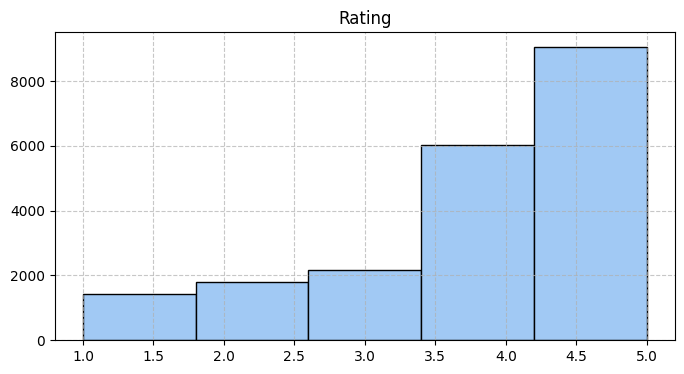

In [9]:
dataset.hist(bins=5, figsize=(8,4), color= sns.color_palette("pastel")[0], edgecolor='black')
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.show()

## We can clearly notice that the classes are not well balanced

thii is a point that we should not forget when we will try to get the best models possible

In [10]:
dataset.describe()

,Rating
count,20491.000000
mean,3.952223
std,1.233030
min,1.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,5.000000


## we will try to do some analysis on the lenght of the review.

In [11]:
n_words = dataset['Review'].str.split().str.len()
n_chars = dataset['Review'].str.len()

In [12]:
pd.DataFrame(n_words.describe())

,Review
count,20491.000000
mean,104.375824
std,100.656586
min,7.000000
25%,48.000000
50%,77.000000
75%,124.000000
max,1931.000000


## due to the fact that we have some review with a number absolutely crazy of words, we may remove between 1 to 5% of the longest review to facilitatte the analysis. 

finally I choose to keep each of them but removing them from the hist in order to have a better view of the repartition. One way to manage this part would be to search the maximum number of word authorized by TripAdvisor. this way if a review is longer it means that it is an error in the dataset.

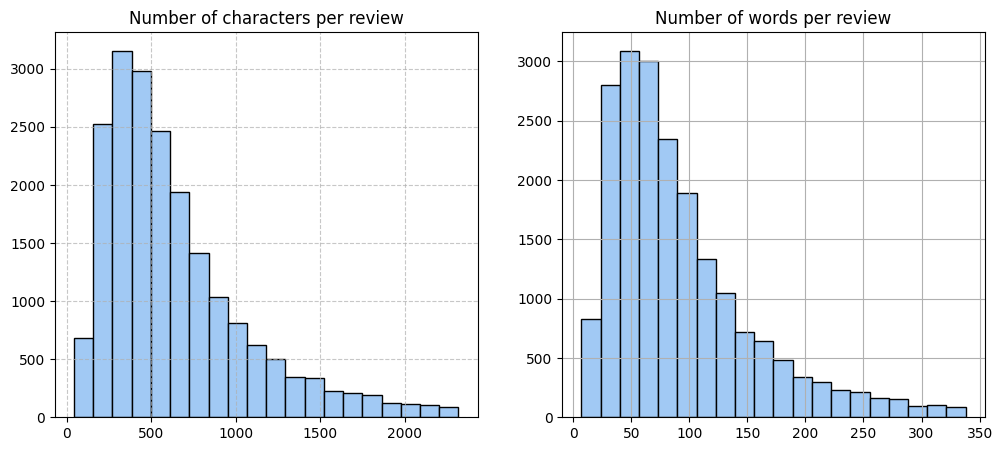

In [13]:
threshold_chars = n_chars.quantile(0.97)
threshold_words = n_words.quantile(0.97)

n_filtered_chars = n_chars[n_chars < threshold_chars]
n_filtered_words = n_words[n_words < threshold_words]

plt.subplot(1,2,1)
plt.title('Number of characters per review')
n_filtered_chars.hist(bins=20, figsize=(12,5), color= sns.color_palette("pastel")[0], edgecolor='black')
plt.grid(axis='both', linestyle='--', alpha=0.7)

plt.subplot(1,2,2)
plt.title('Number of words per review')
n_filtered_words.hist(bins=20, figsize=(12,5), color= sns.color_palette("pastel")[0], edgecolor='black')
plt.show()

Most of the reviews contains between 20 and 150 words and between 100 to 1000 chars

In [14]:
# count if there emoticon in the review
dataset['Review'].str.contains(':\)|:\(|;\)|;\(|:-\)|:-\(|;-\)|;-\(').sum()

0

this was a test to verify that my dataset does not conains these type of datas so that we do not need to manage it in the preprocessing pipeline. Same for emojis

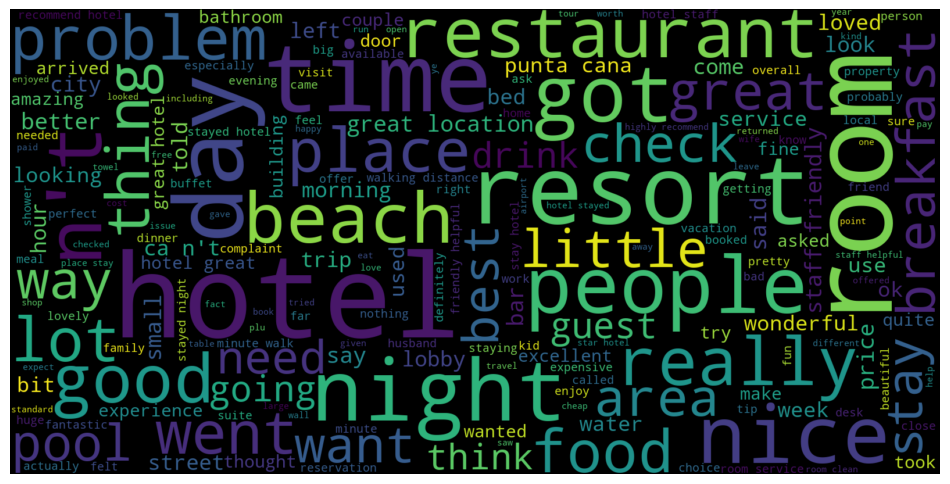

In [21]:
# display the 50 words the most used in the reviews
from collections import Counter
from wordcloud import WordCloud
Counter(" ".join(dataset["Review"]).split()).most_common(50)
wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(" ".join(dataset["Review"]))
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


From the wordcloud it seems like we have a lot of positive words: "amazing", "wonderful", "good", "friendly", et "great" what correspond to the fact that most of the review are positive (4 and 5). on the other way we notice "problem" that describe a negative review. these particular words will probably ne really usefull for the classification of a review. 

some words that are really used may demonstrate the things that are really important for a customers as for exemple: "restaurant", "beach", "pool", "breakfast". we can imagine that when these words are used with the positive words that we talked about, the Rating is very likely to be good. 

À partir de ce nuage de mots, il semble que le thème principal tourne autour des hôtels et des expériences de séjour. Des mots comme "hôtel", "check", "room", "beach", "location", "service", "guest", "night", et "breakfast" sont en évidence, ce qui suggère que ce sont des termes couramment mentionnés. Cela pourrait être basé sur des avis ou des commentaires de clients concernant leurs séjours à l'hôtel.

D'autres mots tels que "amazing", "wonderful", "good", "friendly", et "great" suggèrent que beaucoup des commentaires ou des avis étaient positifs. Cependant, il y a aussi des mots comme "problem", ce qui indique que certains commentaires peuvent avoir mentionné des problèmes ou des préoccupations.

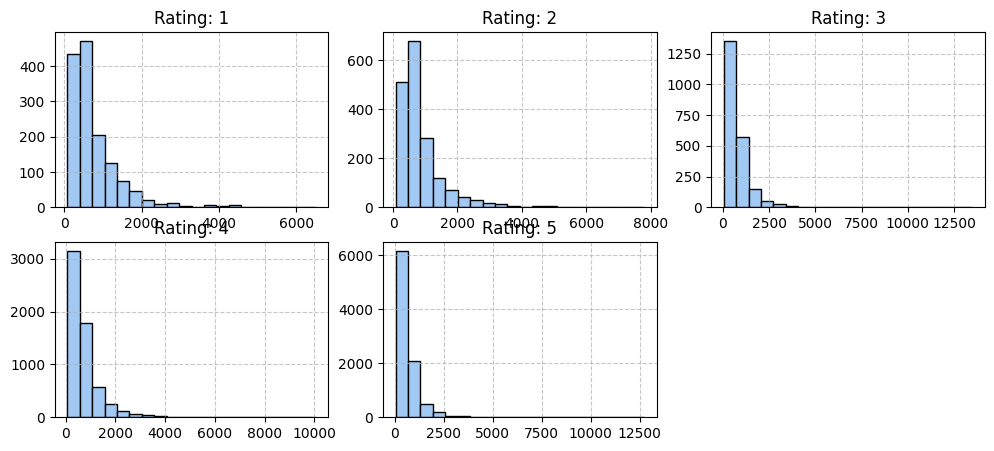

In [29]:
plt.figure(figsize=(12,10))
for i in range(1,6):
    plt.subplot(2,3,i)
    plt.title('Rating: '+str(i))
    dataset[dataset['Rating']==i]['Review'].str.len().hist(bins=20, figsize=(12,5), color= sns.color_palette("pastel")[0], edgecolor='black')
    plt.grid(axis='both', linestyle='--', alpha=0.7)

 

The histogram show that the repartition is approximately the same for each rating but we can notice that 1 stars and 2 stars reviews contains a bit more of long reviews than the others. 